In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


In [0]:
if not os.path.exists('/content/synthetic_images'):
  os.mkdir('/content/synthetic_images')

#### **Define the Hyperparameters**

In [0]:
h = 28
w = 28
# channels
c = 1

shape = h,w,c
latent_dim = 100
iterations = 1000
batch_size = 128
test_interval = 50 

#### Load the dataset

In [0]:
(X_train,_), (X_test,_) = mnist.load_data()
X = np.append(X_train, X_test, axis = 0)

# rescale -1 to 1
X = X/127.5 - 1

X = np.expand_dims(X, axis=3)

# GAN ground truth
valid = np.ones((batch_size,1))
fake = np.zeros((batch_size,1))

In [34]:
X.shape

(70000, 28, 28, 1)

#### Generator

In [0]:
def build_generator():
  model = Sequential()

  # 1st hidden layer
  # input_dim requires a single number
  # input_shape requires a shape syntax(tuple)
  model.add(Dense(256, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))

  # 2nd hidden layer
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))

  # 3rd hidden layer
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))

  # output layer
  model.add(Dense(np.prod(shape), activation='tanh'))

  # reshape in keras
  model.add(Reshape(shape))

  model.summary()

  return model

### Discriminator

In [0]:
def build_discriminator():

  model = Sequential()

  # convert to vector
  model.add(Flatten(input_shape=shape))

  # 1st hidden layer
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))

  # 2nd hidden layer
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))

  # output layer
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  return model

In [0]:
optimizer = Adam(lr=0.0002, beta_1= 0.5)

## Call and compile discriminator

In [47]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer = optimizer,
                      metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

### Call & Compile Generator

In [50]:
generator = build_generator()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 784)              

In [0]:
z = Input(shape=(latent_dim,))
gen_imgs = generator(z)

# declare that discriminator weights and biases are fix
discriminator.trainable = False

validity = discriminator(gen_imgs)

# stacking the generator and non-trainable discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy',
                 optimizer = optimizer)

In [0]:
def test_images(it):
  row, col = 5,5
  noise = np.random.normal(0,1,(row*col, latent_dim))
  synthetic_images = generator.predict(noise)

  # rescale 0 to 1
  synthetic_images = 0.5 * synthetic_images + 0.5

  fig, axs = plt.subplots(row, col)
  t = 0
  for i in range(row):
    for j in range(col):
      axs[i,j].imshow(synthetic_images[t,:,:,0], cmap = 'gray')
      axs[i,j].axis('off')
      t += 1

  fig.savefig(f"/content/synthetic_images/images{it}.png")
  plt.show()

  plt.close()

### Training Loop

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.696681797504425, acc.: 0.5] [G loss: 0.3790723383426666]


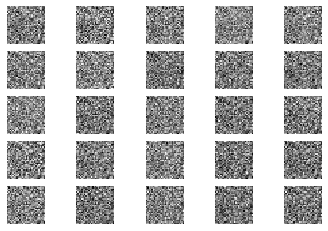

1 [D loss: 0.7857557535171509, acc.: 0.5] [G loss: 0.33955520391464233]
2 [D loss: 0.8385656476020813, acc.: 0.5] [G loss: 0.3492465615272522]
3 [D loss: 0.8209195733070374, acc.: 0.5] [G loss: 0.41873884201049805]
4 [D loss: 0.7423703074455261, acc.: 0.5] [G loss: 0.5464261770248413]
5 [D loss: 0.6634103655815125, acc.: 0.5] [G loss: 0.7084740400314331]
6 [D loss: 0.5951665043830872, acc.: 0.5] [G loss: 0.867706298828125]
7 [D loss: 0.5503122210502625, acc.: 0.5] [G loss: 0.9636436700820923]
8 [D loss: 0.5427153706550598, acc.: 0.5] [G loss: 1.0083134174346924]
9 [D loss: 0.5437864065170288, acc.: 0.5] [G loss: 1.0140981674194336]
10 [D loss: 0.5130596160888672, acc.: 0.5] [G loss: 1.0612244606018066]
11 [D loss: 0.5014199018478394, acc.: 0.5] [G loss: 1.1910741329193115]
12 [D loss: 0.47447437047958374, acc.: 0.5] [G loss: 1.2431628704071045]
13 [D loss: 0.49447739124298096, acc.: 0.5] [G loss: 1.231730580329895]
14 [D loss: 0.5026793479919434, acc.: 0.5] [G loss: 1.2626063823699951]

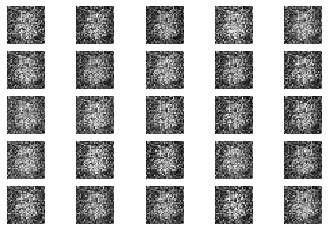

51 [D loss: 0.8092526197433472, acc.: 0.484375] [G loss: 0.7872925996780396]
52 [D loss: 0.8577184081077576, acc.: 0.4609375] [G loss: 0.7459955215454102]
53 [D loss: 0.8648887872695923, acc.: 0.4296875] [G loss: 0.7833536267280579]
54 [D loss: 0.8872880339622498, acc.: 0.43359375] [G loss: 0.7776763439178467]
55 [D loss: 0.8717828989028931, acc.: 0.4375] [G loss: 0.8025057911872864]
56 [D loss: 0.8437418341636658, acc.: 0.42578125] [G loss: 0.8251432180404663]
57 [D loss: 0.8209779262542725, acc.: 0.4609375] [G loss: 0.8960400819778442]
58 [D loss: 0.8937805891036987, acc.: 0.4296875] [G loss: 0.8419163823127747]
59 [D loss: 0.9009534120559692, acc.: 0.43359375] [G loss: 0.866442084312439]
60 [D loss: 0.9199097156524658, acc.: 0.41015625] [G loss: 0.8092793226242065]
61 [D loss: 0.8882160782814026, acc.: 0.4375] [G loss: 0.8154556751251221]
62 [D loss: 0.8727214336395264, acc.: 0.41796875] [G loss: 0.8181816339492798]
63 [D loss: 0.8639130592346191, acc.: 0.44140625] [G loss: 0.810681

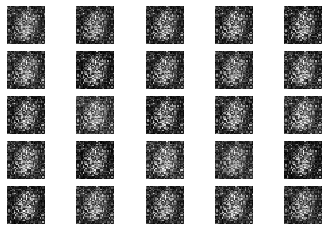

101 [D loss: 0.7533092498779297, acc.: 0.46875] [G loss: 0.928459107875824]
102 [D loss: 0.7533714771270752, acc.: 0.484375] [G loss: 0.8898316621780396]
103 [D loss: 0.7557803392410278, acc.: 0.46875] [G loss: 0.8902429342269897]
104 [D loss: 0.7274740934371948, acc.: 0.484375] [G loss: 0.8952819108963013]
105 [D loss: 0.6805397272109985, acc.: 0.484375] [G loss: 0.9296693801879883]
106 [D loss: 0.6135457158088684, acc.: 0.49609375] [G loss: 1.0180721282958984]
107 [D loss: 0.5598247051239014, acc.: 0.53125] [G loss: 1.12026846408844]
108 [D loss: 0.5494118332862854, acc.: 0.58203125] [G loss: 1.1744794845581055]
109 [D loss: 0.5654164552688599, acc.: 0.52734375] [G loss: 1.1234071254730225]
110 [D loss: 0.6526606678962708, acc.: 0.4765625] [G loss: 0.9815831184387207]
111 [D loss: 0.6720997095108032, acc.: 0.49609375] [G loss: 0.9102973937988281]
112 [D loss: 0.7299945950508118, acc.: 0.484375] [G loss: 0.799983024597168]
113 [D loss: 0.7345269918441772, acc.: 0.4921875] [G loss: 0.7

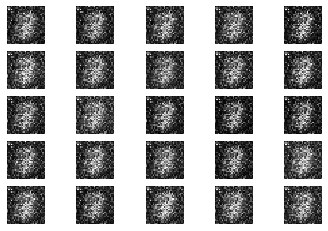

151 [D loss: 0.7495613098144531, acc.: 0.421875] [G loss: 0.7891875505447388]
152 [D loss: 0.6960874199867249, acc.: 0.46875] [G loss: 0.8388543128967285]
153 [D loss: 0.6549988389015198, acc.: 0.49609375] [G loss: 0.8975245952606201]
154 [D loss: 0.6404726505279541, acc.: 0.47265625] [G loss: 0.9013124704360962]
155 [D loss: 0.661977231502533, acc.: 0.46875] [G loss: 0.8753317594528198]
156 [D loss: 0.6724895238876343, acc.: 0.4765625] [G loss: 0.8648805618286133]
157 [D loss: 0.6415629386901855, acc.: 0.4921875] [G loss: 0.9184305667877197]
158 [D loss: 0.6089274287223816, acc.: 0.47265625] [G loss: 0.9796848297119141]
159 [D loss: 0.6000635027885437, acc.: 0.49609375] [G loss: 1.0091028213500977]
160 [D loss: 0.5999125242233276, acc.: 0.5] [G loss: 1.0196772813796997]
161 [D loss: 0.5952283143997192, acc.: 0.5] [G loss: 1.003097414970398]
162 [D loss: 0.6028221845626831, acc.: 0.4921875] [G loss: 0.9878528714179993]
163 [D loss: 0.6327821016311646, acc.: 0.4921875] [G loss: 0.916884

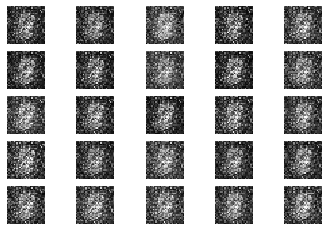

201 [D loss: 0.6467446088790894, acc.: 0.4921875] [G loss: 0.9405277967453003]
202 [D loss: 0.6772583723068237, acc.: 0.4765625] [G loss: 0.9116342663764954]
203 [D loss: 0.6692616939544678, acc.: 0.4765625] [G loss: 0.9243632555007935]
204 [D loss: 0.6491493582725525, acc.: 0.48046875] [G loss: 0.943718433380127]
205 [D loss: 0.6402610540390015, acc.: 0.45703125] [G loss: 0.9572332501411438]
206 [D loss: 0.6540120244026184, acc.: 0.4609375] [G loss: 0.9452253580093384]
207 [D loss: 0.6678094267845154, acc.: 0.46484375] [G loss: 0.9328539371490479]
208 [D loss: 0.644105076789856, acc.: 0.49609375] [G loss: 0.9252816438674927]
209 [D loss: 0.6544259786605835, acc.: 0.4765625] [G loss: 0.9356412291526794]
210 [D loss: 0.6092466115951538, acc.: 0.48828125] [G loss: 0.9973534941673279]
211 [D loss: 0.6295177936553955, acc.: 0.4453125] [G loss: 0.9926304817199707]
212 [D loss: 0.6510649919509888, acc.: 0.4375] [G loss: 0.9831010699272156]
213 [D loss: 0.6182066202163696, acc.: 0.47265625] [

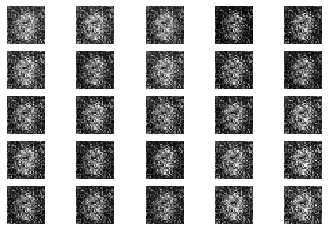

251 [D loss: 0.570025622844696, acc.: 0.5625] [G loss: 1.0732126235961914]
252 [D loss: 0.5771807432174683, acc.: 0.59765625] [G loss: 1.0612046718597412]
253 [D loss: 0.5754116773605347, acc.: 0.59375] [G loss: 1.06754469871521]
254 [D loss: 0.6476383805274963, acc.: 0.48828125] [G loss: 0.9975878000259399]
255 [D loss: 0.6032453179359436, acc.: 0.59765625] [G loss: 1.0334391593933105]
256 [D loss: 0.5893707275390625, acc.: 0.640625] [G loss: 1.0992541313171387]
257 [D loss: 0.5788832902908325, acc.: 0.640625] [G loss: 1.1167845726013184]
258 [D loss: 0.5861757397651672, acc.: 0.61328125] [G loss: 1.0687717199325562]
259 [D loss: 0.6026622653007507, acc.: 0.56640625] [G loss: 0.9874460697174072]
260 [D loss: 0.6540104746818542, acc.: 0.48828125] [G loss: 0.9923712015151978]
261 [D loss: 0.6367762088775635, acc.: 0.48046875] [G loss: 0.9945152997970581]
262 [D loss: 0.6605855226516724, acc.: 0.4375] [G loss: 0.9816893339157104]
263 [D loss: 0.6188976764678955, acc.: 0.5] [G loss: 1.090

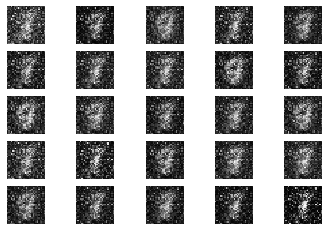

301 [D loss: 0.7080782651901245, acc.: 0.375] [G loss: 0.9035522937774658]
302 [D loss: 0.665475606918335, acc.: 0.4375] [G loss: 0.9282369613647461]
303 [D loss: 0.6454812288284302, acc.: 0.39453125] [G loss: 0.9508427381515503]
304 [D loss: 0.5797573924064636, acc.: 0.66015625] [G loss: 1.027470350265503]
305 [D loss: 0.5693429112434387, acc.: 0.671875] [G loss: 1.033644199371338]
306 [D loss: 0.6092536449432373, acc.: 0.59375] [G loss: 0.9497920870780945]
307 [D loss: 0.5894854664802551, acc.: 0.58984375] [G loss: 0.9541951417922974]
308 [D loss: 0.6001659035682678, acc.: 0.57421875] [G loss: 0.9828534126281738]
309 [D loss: 0.6180130243301392, acc.: 0.55078125] [G loss: 0.9859133958816528]
310 [D loss: 0.584515392780304, acc.: 0.609375] [G loss: 1.0238559246063232]
311 [D loss: 0.5654399394989014, acc.: 0.67578125] [G loss: 1.07607901096344]
312 [D loss: 0.5377734899520874, acc.: 0.76171875] [G loss: 1.1228318214416504]
313 [D loss: 0.5658805966377258, acc.: 0.6953125] [G loss: 1.1

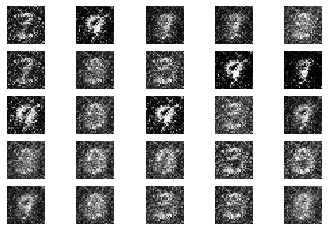

351 [D loss: 0.6407371759414673, acc.: 0.61328125] [G loss: 0.9629694223403931]
352 [D loss: 0.677449107170105, acc.: 0.5859375] [G loss: 0.9106059074401855]
353 [D loss: 0.65836501121521, acc.: 0.58984375] [G loss: 0.9099115133285522]
354 [D loss: 0.6500436067581177, acc.: 0.625] [G loss: 0.8662577271461487]
355 [D loss: 0.691916823387146, acc.: 0.58203125] [G loss: 0.855902910232544]
356 [D loss: 0.6420365571975708, acc.: 0.6328125] [G loss: 0.8822942972183228]
357 [D loss: 0.6404721140861511, acc.: 0.62890625] [G loss: 0.9039295315742493]
358 [D loss: 0.654107391834259, acc.: 0.5625] [G loss: 0.9023313522338867]
359 [D loss: 0.600447952747345, acc.: 0.65625] [G loss: 0.9330686330795288]
360 [D loss: 0.6357623338699341, acc.: 0.6171875] [G loss: 0.9295629262924194]
361 [D loss: 0.6123210787773132, acc.: 0.59375] [G loss: 0.958812415599823]
362 [D loss: 0.6544938683509827, acc.: 0.48828125] [G loss: 0.905788242816925]
363 [D loss: 0.6497728228569031, acc.: 0.51171875] [G loss: 0.89982

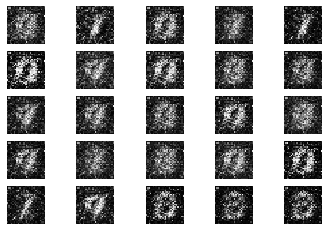

401 [D loss: 0.5745349526405334, acc.: 0.67578125] [G loss: 0.9647934436798096]
402 [D loss: 0.564858615398407, acc.: 0.69140625] [G loss: 1.0167721509933472]
403 [D loss: 0.5683905482292175, acc.: 0.6640625] [G loss: 1.0277104377746582]
404 [D loss: 0.5908976197242737, acc.: 0.703125] [G loss: 1.0252892971038818]
405 [D loss: 0.6118984222412109, acc.: 0.6328125] [G loss: 0.9642800092697144]
406 [D loss: 0.5976572036743164, acc.: 0.5703125] [G loss: 0.9395092725753784]
407 [D loss: 0.6241756677627563, acc.: 0.59375] [G loss: 0.9404624700546265]
408 [D loss: 0.6307505369186401, acc.: 0.55078125] [G loss: 0.9234663248062134]
409 [D loss: 0.6378921866416931, acc.: 0.5234375] [G loss: 0.9083738327026367]
410 [D loss: 0.6162463426589966, acc.: 0.515625] [G loss: 0.9210587739944458]
411 [D loss: 0.5888246893882751, acc.: 0.59765625] [G loss: 0.9435287714004517]
412 [D loss: 0.5485209822654724, acc.: 0.7109375] [G loss: 0.9821387529373169]
413 [D loss: 0.5595141649246216, acc.: 0.76953125] [G

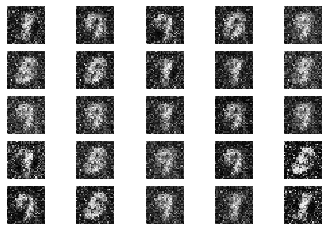

451 [D loss: 0.5940603017807007, acc.: 0.6171875] [G loss: 1.0391380786895752]
452 [D loss: 0.6419726610183716, acc.: 0.53515625] [G loss: 1.027569055557251]
453 [D loss: 0.6082106828689575, acc.: 0.58984375] [G loss: 1.039807915687561]
454 [D loss: 0.6349172592163086, acc.: 0.546875] [G loss: 1.0311424732208252]
455 [D loss: 0.6349169015884399, acc.: 0.5625] [G loss: 1.0123326778411865]
456 [D loss: 0.6333535313606262, acc.: 0.53125] [G loss: 1.0124123096466064]
457 [D loss: 0.6744546294212341, acc.: 0.4453125] [G loss: 0.978713870048523]
458 [D loss: 0.642256498336792, acc.: 0.43359375] [G loss: 1.0063161849975586]
459 [D loss: 0.6659221649169922, acc.: 0.44921875] [G loss: 1.0358755588531494]
460 [D loss: 0.6764206290245056, acc.: 0.453125] [G loss: 1.0063698291778564]
461 [D loss: 0.666153073310852, acc.: 0.44921875] [G loss: 1.0208847522735596]
462 [D loss: 0.6358267068862915, acc.: 0.45703125] [G loss: 1.0240628719329834]
463 [D loss: 0.6272167563438416, acc.: 0.49609375] [G loss

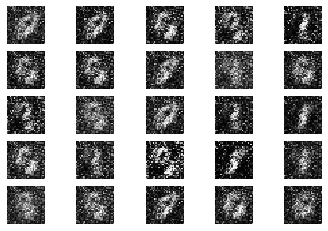

501 [D loss: 0.6693513989448547, acc.: 0.41015625] [G loss: 1.0534676313400269]
502 [D loss: 0.5925143957138062, acc.: 0.58984375] [G loss: 1.135190725326538]
503 [D loss: 0.5646973252296448, acc.: 0.7890625] [G loss: 1.2020540237426758]
504 [D loss: 0.5649384260177612, acc.: 0.76953125] [G loss: 1.1774952411651611]
505 [D loss: 0.5572109818458557, acc.: 0.75] [G loss: 1.1378364562988281]
506 [D loss: 0.5681968927383423, acc.: 0.65625] [G loss: 1.0953302383422852]
507 [D loss: 0.5585024356842041, acc.: 0.625] [G loss: 1.0843226909637451]
508 [D loss: 0.5528439879417419, acc.: 0.6640625] [G loss: 1.1073558330535889]
509 [D loss: 0.5356082320213318, acc.: 0.71484375] [G loss: 1.0937390327453613]
510 [D loss: 0.5513814687728882, acc.: 0.71875] [G loss: 1.0989395380020142]
511 [D loss: 0.5518788695335388, acc.: 0.6953125] [G loss: 1.1033014059066772]
512 [D loss: 0.5583162903785706, acc.: 0.703125] [G loss: 1.1053776741027832]
513 [D loss: 0.5716496109962463, acc.: 0.62109375] [G loss: 1.0

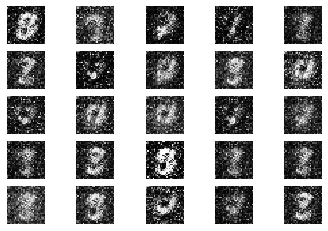

551 [D loss: 0.681200385093689, acc.: 0.55859375] [G loss: 1.039844274520874]
552 [D loss: 0.7593103647232056, acc.: 0.4453125] [G loss: 0.9236357808113098]
553 [D loss: 0.7241140604019165, acc.: 0.46875] [G loss: 0.9942837357521057]
554 [D loss: 0.6784988641738892, acc.: 0.57421875] [G loss: 1.1032439470291138]
555 [D loss: 0.6636955738067627, acc.: 0.53125] [G loss: 1.1414990425109863]
556 [D loss: 0.6420437097549438, acc.: 0.5859375] [G loss: 1.1609821319580078]
557 [D loss: 0.6271740198135376, acc.: 0.59765625] [G loss: 1.1615040302276611]
558 [D loss: 0.6309154629707336, acc.: 0.5] [G loss: 1.1793439388275146]
559 [D loss: 0.6394441723823547, acc.: 0.546875] [G loss: 1.1350795030593872]
560 [D loss: 0.6713382601737976, acc.: 0.45703125] [G loss: 1.087918996810913]
561 [D loss: 0.6713924407958984, acc.: 0.53515625] [G loss: 1.0794966220855713]
562 [D loss: 0.7293378114700317, acc.: 0.4765625] [G loss: 1.0096745491027832]
563 [D loss: 0.6863362789154053, acc.: 0.46484375] [G loss: 1

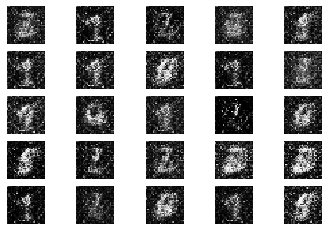

601 [D loss: 0.670525312423706, acc.: 0.4375] [G loss: 0.9559072256088257]
602 [D loss: 0.6439968347549438, acc.: 0.48828125] [G loss: 0.9780598878860474]
603 [D loss: 0.61161208152771, acc.: 0.66015625] [G loss: 1.0325638055801392]
604 [D loss: 0.6144242882728577, acc.: 0.66015625] [G loss: 1.0765717029571533]
605 [D loss: 0.5993834733963013, acc.: 0.6796875] [G loss: 1.113898754119873]
606 [D loss: 0.5543085336685181, acc.: 0.80859375] [G loss: 1.1107393503189087]
607 [D loss: 0.5858479142189026, acc.: 0.7109375] [G loss: 1.0993859767913818]
608 [D loss: 0.5901861190795898, acc.: 0.66796875] [G loss: 1.0393747091293335]
609 [D loss: 0.6193246841430664, acc.: 0.60546875] [G loss: 1.0115227699279785]
610 [D loss: 0.6693264245986938, acc.: 0.53125] [G loss: 0.9751902222633362]
611 [D loss: 0.629502534866333, acc.: 0.56640625] [G loss: 0.9938563108444214]
612 [D loss: 0.6549113392829895, acc.: 0.5390625] [G loss: 0.9956334829330444]
613 [D loss: 0.6554161906242371, acc.: 0.515625] [G los

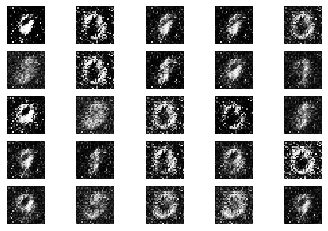

651 [D loss: 0.6135942935943604, acc.: 0.609375] [G loss: 1.016129732131958]
652 [D loss: 0.6116783022880554, acc.: 0.58203125] [G loss: 1.0707159042358398]
653 [D loss: 0.6334654092788696, acc.: 0.58203125] [G loss: 1.0399236679077148]
654 [D loss: 0.6215147972106934, acc.: 0.59375] [G loss: 1.020843505859375]
655 [D loss: 0.6034821271896362, acc.: 0.6328125] [G loss: 1.0288829803466797]
656 [D loss: 0.6529634594917297, acc.: 0.4921875] [G loss: 0.9945083856582642]
657 [D loss: 0.6110422611236572, acc.: 0.60546875] [G loss: 1.0346405506134033]
658 [D loss: 0.5955039262771606, acc.: 0.69140625] [G loss: 1.0505462884902954]
659 [D loss: 0.5691384077072144, acc.: 0.79296875] [G loss: 1.0879848003387451]
660 [D loss: 0.5713918209075928, acc.: 0.765625] [G loss: 1.0884640216827393]
661 [D loss: 0.5790630578994751, acc.: 0.7265625] [G loss: 1.07529616355896]
662 [D loss: 0.5809285640716553, acc.: 0.7109375] [G loss: 1.084244728088379]
663 [D loss: 0.5898610353469849, acc.: 0.72265625] [G lo

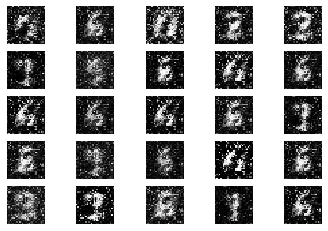

701 [D loss: 0.5542343258857727, acc.: 0.78125] [G loss: 1.188712477684021]
702 [D loss: 0.5651824474334717, acc.: 0.75390625] [G loss: 1.1518058776855469]
703 [D loss: 0.5460469722747803, acc.: 0.73046875] [G loss: 1.1743123531341553]
704 [D loss: 0.5863814353942871, acc.: 0.734375] [G loss: 1.1460351943969727]
705 [D loss: 0.5401582717895508, acc.: 0.75390625] [G loss: 1.1171936988830566]
706 [D loss: 0.5756822824478149, acc.: 0.6796875] [G loss: 1.1076023578643799]
707 [D loss: 0.5753678679466248, acc.: 0.6640625] [G loss: 1.149355173110962]
708 [D loss: 0.5457298755645752, acc.: 0.73046875] [G loss: 1.1992058753967285]
709 [D loss: 0.5869185328483582, acc.: 0.67578125] [G loss: 1.141594648361206]
710 [D loss: 0.622917652130127, acc.: 0.640625] [G loss: 1.0598913431167603]
711 [D loss: 0.6521776914596558, acc.: 0.515625] [G loss: 1.0842673778533936]
712 [D loss: 0.6802105903625488, acc.: 0.4765625] [G loss: 0.9925925135612488]
713 [D loss: 0.6620817184448242, acc.: 0.515625] [G loss

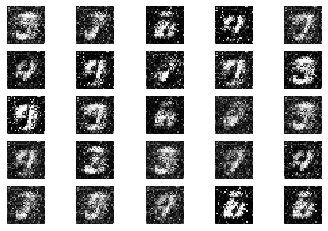

751 [D loss: 0.5530774593353271, acc.: 0.80078125] [G loss: 1.115687370300293]
752 [D loss: 0.5506599545478821, acc.: 0.76171875] [G loss: 1.1745195388793945]
753 [D loss: 0.5256531238555908, acc.: 0.8203125] [G loss: 1.1526455879211426]
754 [D loss: 0.5257995128631592, acc.: 0.80078125] [G loss: 1.1960231065750122]
755 [D loss: 0.48681145906448364, acc.: 0.80859375] [G loss: 1.2811414003372192]
756 [D loss: 0.560537576675415, acc.: 0.73046875] [G loss: 1.2309304475784302]
757 [D loss: 0.6039125323295593, acc.: 0.63671875] [G loss: 1.2454261779785156]
758 [D loss: 0.5853880047798157, acc.: 0.72265625] [G loss: 1.1840964555740356]
759 [D loss: 0.6667793393135071, acc.: 0.55859375] [G loss: 1.0940368175506592]
760 [D loss: 0.6302735209465027, acc.: 0.5859375] [G loss: 1.117020845413208]
761 [D loss: 0.631591260433197, acc.: 0.55078125] [G loss: 1.1636734008789062]
762 [D loss: 0.7110729217529297, acc.: 0.484375] [G loss: 1.106793999671936]
763 [D loss: 0.6736527681350708, acc.: 0.4960937

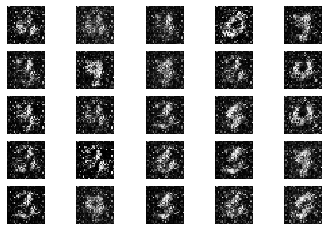

801 [D loss: 0.5861399173736572, acc.: 0.7265625] [G loss: 1.2861578464508057]
802 [D loss: 0.5526576638221741, acc.: 0.80078125] [G loss: 1.3217968940734863]
803 [D loss: 0.6208832859992981, acc.: 0.6015625] [G loss: 1.2080481052398682]
804 [D loss: 0.5895434617996216, acc.: 0.66015625] [G loss: 1.2327154874801636]
805 [D loss: 0.6719930171966553, acc.: 0.5703125] [G loss: 1.191787838935852]
806 [D loss: 0.6267358064651489, acc.: 0.60546875] [G loss: 1.204237461090088]
807 [D loss: 0.6993324756622314, acc.: 0.48828125] [G loss: 1.1089184284210205]
808 [D loss: 0.6084816455841064, acc.: 0.66796875] [G loss: 1.183653473854065]
809 [D loss: 0.6628852486610413, acc.: 0.5703125] [G loss: 1.1189264059066772]
810 [D loss: 0.6426548957824707, acc.: 0.59375] [G loss: 1.1784615516662598]
811 [D loss: 0.6318520903587341, acc.: 0.5859375] [G loss: 1.1021406650543213]
812 [D loss: 0.5940707921981812, acc.: 0.6953125] [G loss: 1.1334760189056396]
813 [D loss: 0.6345911622047424, acc.: 0.57421875] [

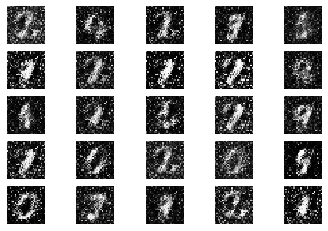

851 [D loss: 0.5980290174484253, acc.: 0.66796875] [G loss: 1.0553090572357178]
852 [D loss: 0.6327677965164185, acc.: 0.55078125] [G loss: 1.0646851062774658]
853 [D loss: 0.6350955963134766, acc.: 0.5625] [G loss: 1.0862579345703125]
854 [D loss: 0.6090072393417358, acc.: 0.671875] [G loss: 1.1241116523742676]
855 [D loss: 0.5743602514266968, acc.: 0.73828125] [G loss: 1.1272022724151611]
856 [D loss: 0.578528881072998, acc.: 0.7421875] [G loss: 1.195327877998352]
857 [D loss: 0.58305823802948, acc.: 0.69140625] [G loss: 1.1723814010620117]
858 [D loss: 0.6485814452171326, acc.: 0.6171875] [G loss: 1.1148892641067505]
859 [D loss: 0.5930639505386353, acc.: 0.70703125] [G loss: 1.156416893005371]
860 [D loss: 0.6124503016471863, acc.: 0.66796875] [G loss: 1.073106050491333]
861 [D loss: 0.6195434927940369, acc.: 0.6171875] [G loss: 1.1246039867401123]
862 [D loss: 0.6387882232666016, acc.: 0.6015625] [G loss: 1.1069097518920898]
863 [D loss: 0.5667976140975952, acc.: 0.75390625] [G lo

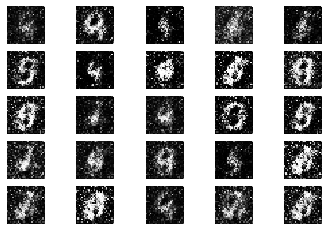

901 [D loss: 0.5860102772712708, acc.: 0.70703125] [G loss: 1.1419763565063477]
902 [D loss: 0.5864294767379761, acc.: 0.6875] [G loss: 1.2088630199432373]
903 [D loss: 0.5618140697479248, acc.: 0.74609375] [G loss: 1.2271031141281128]
904 [D loss: 0.5547142624855042, acc.: 0.76171875] [G loss: 1.237444519996643]
905 [D loss: 0.5696830153465271, acc.: 0.75390625] [G loss: 1.2720519304275513]
906 [D loss: 0.5890081524848938, acc.: 0.6953125] [G loss: 1.27679443359375]
907 [D loss: 0.6361914277076721, acc.: 0.6875] [G loss: 1.2377140522003174]
908 [D loss: 0.5924893617630005, acc.: 0.7109375] [G loss: 1.2297122478485107]
909 [D loss: 0.6017677783966064, acc.: 0.71484375] [G loss: 1.2467145919799805]
910 [D loss: 0.5562702417373657, acc.: 0.78125] [G loss: 1.298359751701355]
911 [D loss: 0.5836968421936035, acc.: 0.77734375] [G loss: 1.2867488861083984]
912 [D loss: 0.5782269239425659, acc.: 0.70703125] [G loss: 1.302005410194397]
913 [D loss: 0.5875422954559326, acc.: 0.69140625] [G loss

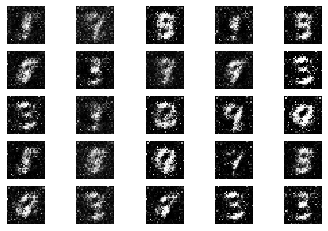

951 [D loss: 0.578275740146637, acc.: 0.73828125] [G loss: 1.1128023862838745]
952 [D loss: 0.5510560870170593, acc.: 0.80078125] [G loss: 1.1267528533935547]
953 [D loss: 0.6339595913887024, acc.: 0.68359375] [G loss: 1.0864838361740112]
954 [D loss: 0.5444236993789673, acc.: 0.74609375] [G loss: 1.1463981866836548]
955 [D loss: 0.5934790372848511, acc.: 0.7265625] [G loss: 1.1693077087402344]
956 [D loss: 0.5378939509391785, acc.: 0.8046875] [G loss: 1.1739596128463745]
957 [D loss: 0.5632004141807556, acc.: 0.76171875] [G loss: 1.189185619354248]
958 [D loss: 0.549235463142395, acc.: 0.8125] [G loss: 1.1898329257965088]
959 [D loss: 0.5612529516220093, acc.: 0.77734375] [G loss: 1.1754728555679321]
960 [D loss: 0.5495460033416748, acc.: 0.81640625] [G loss: 1.1571377515792847]
961 [D loss: 0.5794587135314941, acc.: 0.75390625] [G loss: 1.1494591236114502]
962 [D loss: 0.5611075162887573, acc.: 0.765625] [G loss: 1.1523642539978027]
963 [D loss: 0.5748363137245178, acc.: 0.73828125] 

In [66]:
for it in range(iterations):

  ## 1st part: Train the discriminator

  # select a random batch from real dataset
  idx = np.random.randint(0, X.shape[0], batch_size)
  imgs = X[idx]

  # generate synthetic data
  noise = np.random.normal(0, 1, (batch_size, latent_dim))
  fake_imgs = generator.predict(noise)

  # train the discriminator
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  ## 2nd part: Train the generator(combined)
  # generate synthetic data
  noise = np.random.normal(0,1 , (batch_size, latent_dim))

  # train the generator
  g_loss = combined.train_on_batch(noise, valid)

  # plot the progress
  print (f"{it} [D loss: {d_loss[0]}, acc.: {d_loss[1]}] [G loss: {g_loss}]")

  if it % test_interval == 0:
    test_images(it)